In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout

!pip install fastparquet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.9 MB/s eta 0:00:00


In [2]:
# Read the processed dataset.
semg_df = pd.read_parquet('/content/drive/MyDrive/sEMG-HAR/semg_extracted_scalar_features_only', engine='fastparquet')

semg_df[:20]

,subject_id,activity,trial_index,semg_1_td_mean,semg_1_td_rms,semg_1_td_sd,semg_1_td_var,semg_1_td_iemg,semg_1_td_zcr,semg_1_td_ssc,...,semg_1_fd_medfreq_10,semg_1_fd_meanfreq_10,semg_2_fd_medfreq_10,semg_2_fd_meanfreq_10,semg_3_fd_medfreq_10,semg_3_fd_meanfreq_10,semg_4_fd_medfreq_10,semg_4_fd_meanfreq_10,semg_5_fd_medfreq_10,semg_5_fd_meanfreq_10
0,5,20,3,0.007527,32.994613,32.994613,1088.644456,465531.475412,2317,4180,...,62.307692,83.255459,73.846154,83.732269,76.923077,89.203694,54.615385,68.565184,140.000000,151.179692
1,10,20,4,-0.006587,44.476383,44.476383,1978.148624,429311.110991,2114,4012,...,60.000000,79.565346,62.307692,75.266022,82.307692,103.912684,47.692308,59.068912,113.846154,120.680429
2,6,20,10,0.001336,8.073858,8.073858,65.187177,124953.964457,3182,5333,...,68.461538,90.873446,82.307692,92.636607,70.769231,84.011051,54.615385,57.018461,196.923077,191.155784
3,1,20,9,0.002790,21.087234,21.087233,444.671412,324534.585663,2833,4778,...,75.384615,88.117086,83.846154,107.848811,85.384615,93.238580,48.461538,55.395114,70.769231,107.727990
4,8,20,10,0.000866,41.998197,41.998197,1763.848562,481195.451785,3024,5038,...,98.461538,112.136944,102.307692,110.077991,107.692308,125.553742,80.769231,102.396216,123.846154,132.726606
5,10,20,9,-0.000104,29.866473,29.866473,892.006224,371618.096396,2104,4195,...,62.307692,75.997456,62.307692,77.141730,89.230769,110.052456,50.769231,64.191743,123.076923,130.268614
6,5,20,10,-0.001610,23.515816,23.515816,552.993623,312841.470273,2664,4679,...,63.846154,80.893542,68.461538,87.110857,76.153846,85.456215,56.153846,68.904243,146.923077,155.380338
7,6,20,8,0.001408,9.770201,9.770201,95.456828,157418.279922,3082,5195,...,71.538462,96.656070,95.384615,98.281737,85.384615,98.238728,49.230769,59.505960,59.230769,110.450306
8,10,20,3,-0.005311,42.514901,42.514901,1807.516813,474062.018719,2197,4076,...,48.461538,64.289232,63.076923,71.558839,80.769231,106.081482,43.846154,54.292486,103.846154,114.679213
9,7,20,3,0.001894,26.773284,26.773283,716.808707,381344.081222,2433,4198,...,90.000000,100.866746,66.923077,80.253866,113.846154,116.763204,63.076923,73.629890,125.384615,132.829622


In [3]:
# print(semg_df.columns)

X = semg_df.drop(columns=['activity']).astype('float32')
y = semg_df['activity'].astype('int')

# One-hot encoding for the labels
y = to_categorical(y-1, num_classes=21)

# Extract the 'activity' column from the one-hot encoded labels
activity_labels = np.argmax(y, axis=1)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=activity_labels)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

print(X_train.shape)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train_scaled.values, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test = np.reshape(X_test_scaled.values, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(X_train.shape)


(940, 552)
(940, 1, 552)


# Simple LSTM model

In [ ]:
from keras.regularizers import l1_l2

# Define L1/L2 regularizer
l1_l2_reg = l1_l2(l1=0.005, l2=0.005)

# LSTM model
model = Sequential()

# LSTM Input Layer
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2]),
               kernel_regularizer=l1_l2_reg,
               recurrent_regularizer=l1_l2_reg,
               bias_regularizer=l1_l2_reg
              )
          )

# Dropout Layer
model.add(Dropout(0.5))

# Final Dense Layer
model.add(Dense(21, activation='softmax'))  # 21 units in the output layer for 21 classes

# Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test))


Epoch 1/500
8/8 [==============================] - 3s 76ms/step - loss: 117.2719 - accuracy: 0.0894 - val_loss: 98.8377 - val_accuracy: 0.1441
Epoch 2/500
8/8 [==============================] - 0s 8ms/step - loss: 88.1141 - accuracy: 0.2000 - val_loss: 73.1049 - val_accuracy: 0.1949
Epoch 3/500
8/8 [==============================] - 0s 8ms/step - loss: 64.4048 - accuracy: 0.2606 - val_loss: 52.3793 - val_accuracy: 0.2500
Epoch 4/500
8/8 [==============================] - 0s 8ms/step - loss: 45.4992 - accuracy: 0.3319 - val_loss: 36.1345 - val_accuracy: 0.3093
Epoch 5/500
8/8 [==============================] - 0s 8ms/step - loss: 30.9005 - accuracy: 0.4064 - val_loss: 23.9902 - val_accuracy: 0.3051
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 20.2584 - accuracy: 0.4436 - val_loss: 15.5130 - val_accuracy: 0.3220
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 13.1903 - accuracy: 0.4287 - val_loss: 10.4804 - val_accuracy: 0.3390
Epoch 8/500

8/8 [==============================] - 0s 2ms/step
Validation Set Metrics:
Accuracy: 0.7627
Precision: 0.7735
Recall: 0.7627
F1-Score: 0.7622


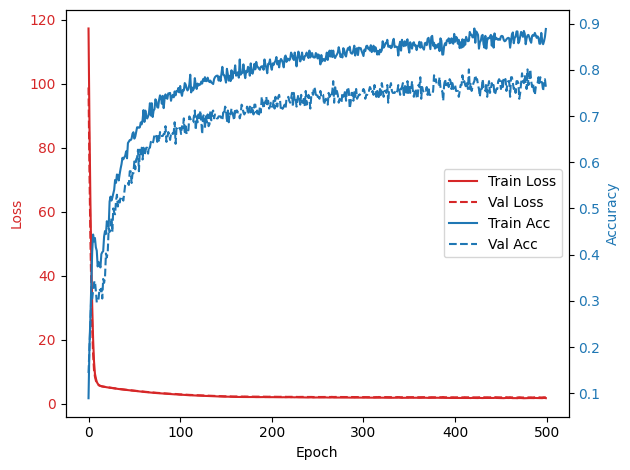

8/8 [==============================] - 0s 2ms/step


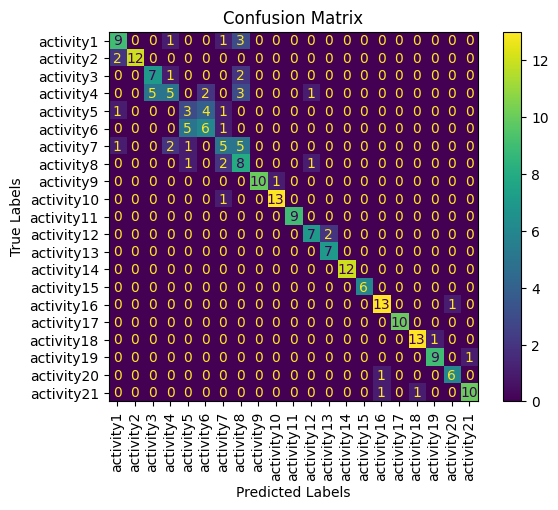

y_val (236, 21)


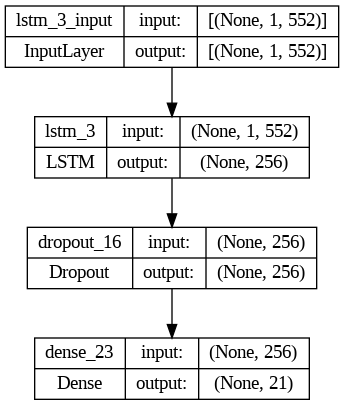

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the validation set
y_val_pred = model.predict(X_test)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_test.shape)

from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))


Stacked LSTM

In [ ]:
from keras.regularizers import l1_l2

# Define L1/L2 regularizer
l1_l2_reg = l1_l2(l1=0.002, l2=0.002)


#Stacked LSTM
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
              recurrent_regularizer=l1_l2_reg,
              kernel_regularizer=l1_l2_reg,
              bias_regularizer=l1_l2_reg
          ))
model.add(Dropout(0.5))
model.add(LSTM(128))
# model.add(Dropout(0.5))
model.add(Dense(21, activation='softmax'))

# Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test))


Epoch 1/500
8/8 [==============================] - 4s 167ms/step - loss: 28.4621 - accuracy: 0.1106 - val_loss: 25.1715 - val_accuracy: 0.2203
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 23.1810 - accuracy: 0.2202 - val_loss: 20.3478 - val_accuracy: 0.2246
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 18.6268 - accuracy: 0.2660 - val_loss: 16.2095 - val_accuracy: 0.1907
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 14.7391 - accuracy: 0.2457 - val_loss: 12.7041 - val_accuracy: 0.1525
Epoch 5/500
8/8 [==============================] - 0s 9ms/step - loss: 11.4650 - accuracy: 0.2074 - val_loss: 9.8018 - val_accuracy: 0.1229
Epoch 6/500
8/8 [==============================] - 0s 9ms/step - loss: 8.7878 - accuracy: 0.1713 - val_loss: 7.4860 - val_accuracy: 0.1059
Epoch 7/500
8/8 [==============================] - 0s 9ms/step - loss: 6.6990 - accuracy: 0.1585 - val_loss: 5.7424 - val_accuracy: 0.0932
Epoch 8/500
8/8 

8/8 [==============================] - 1s 2ms/step
Validation Set Metrics:
Accuracy: 0.7627
Precision: 0.7839
Recall: 0.7627
F1-Score: 0.7591


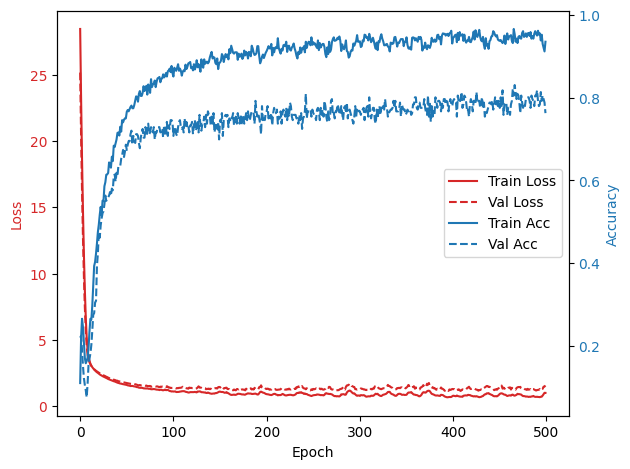

8/8 [==============================] - 0s 3ms/step


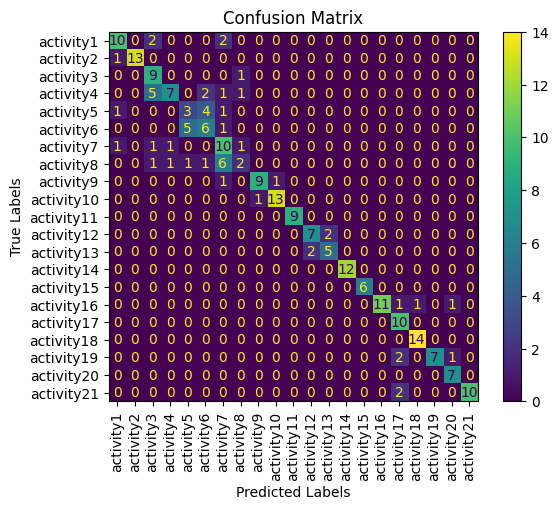

y_val (236, 21)


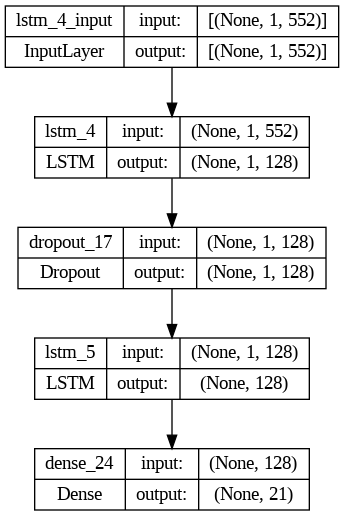

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the validation set
y_val_pred = model.predict(X_test)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_test.shape)

from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))


Bidirectional LSTM

In [ ]:
from keras.regularizers import l1_l2

# Define L1/L2 regularizer
l1_l2_reg = l1_l2(l1=0.002, l2=0.002)

model = Sequential()
model.add(Bidirectional(LSTM(512,
              recurrent_regularizer=l1_l2_reg,
              kernel_regularizer=l1_l2_reg,
              bias_regularizer=l1_l2_reg
), input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(0.6))
model.add(Dense(21, activation='softmax'))

# Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=350, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/350
15/15 [==============================] - 4s 64ms/step - loss: 144.0615 - accuracy: 0.2766 - val_loss: 93.7809 - val_accuracy: 0.3602
Epoch 2/350
15/15 [==============================] - 0s 7ms/step - loss: 65.6893 - accuracy: 0.5606 - val_loss: 39.3796 - val_accuracy: 0.5339
Epoch 3/350
15/15 [==============================] - 0s 7ms/step - loss: 26.5519 - accuracy: 0.6543 - val_loss: 16.2867 - val_accuracy: 0.5297
Epoch 4/350
15/15 [==============================] - 0s 7ms/step - loss: 13.1668 - accuracy: 0.6202 - val_loss: 10.4431 - val_accuracy: 0.5339
Epoch 5/350
15/15 [==============================] - 0s 7ms/step - loss: 9.2994 - accuracy: 0.6298 - val_loss: 8.4473 - val_accuracy: 0.5636
Epoch 6/350
15/15 [==============================] - 0s 8ms/step - loss: 8.0255 - accuracy: 0.5862 - val_loss: 7.7647 - val_accuracy: 0.5805
Epoch 7/350
15/15 [==============================] - 0s 7ms/step - loss: 7.5637 - accuracy: 0.6340 - val_loss: 7.4563 - val_accuracy: 0.5932
Epo

In [ ]:
from sklearn.model_selection import KFold
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# Assuming X is your feature DataFrame and y is your target NumPy array
# Converting X to a NumPy array can help with indexing
X_array = X.to_numpy()
y_array = y  # Since y is already a NumPy array, no need to convert

# Number of splits
n_splits = 5

# KFold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
val_loss_scores = []
val_acc_scores = []

# Loop through the k-folds
for train_index, val_index in kf.split(X_array):
    X_train_fold, X_val_fold = X_array[train_index], X_array[val_index]
    y_train_fold, y_val_fold = y_array[train_index], y_array[val_index]

    # Standardize the features (important to avoid data leakage, hence done inside the loop)
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)

    # Reshape data to be 3D, if it's 2D
    if len(X_train_fold.shape) == 2:
        X_train_fold = np.reshape(X_train_fold, (X_train_fold.shape[0], 1, X_train_fold.shape[1]))
        X_val_fold = np.reshape(X_val_fold, (X_val_fold.shape[0], 1, X_val_fold.shape[1]))

    # Build the model
    l1_l2_reg = l1_l2(l1=0.002, l2=0.002)

    model = Sequential()
    model.add(Bidirectional(LSTM(128,
                  recurrent_regularizer=l1_l2_reg,
                  kernel_regularizer=l1_l2_reg,
                  bias_regularizer=l1_l2_reg
    ), input_shape=(X_train_fold.shape[1], X_train_fold.shape[2])
    ))
    model.add(Dropout(0.6))
    model.add(Dense(21, activation='softmax'))

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Compile and fit the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_fold, y_train_fold, epochs=350, batch_size=64,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping], verbose=0)  # Set verbose=0 for less output

    # Evaluate the model
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

    print("Val Loss during fold: ", val_loss)
    print("Val Acc during fold: ", val_acc)

    # Append the scores
    val_loss_scores.append(val_loss)
    val_acc_scores.append(val_acc)

# Average scores
avg_val_loss = np.mean(val_loss_scores)
avg_val_acc = np.mean(val_acc_scores)

print(f"Average validation loss: {avg_val_loss}")
print(f"Average validation accuracy: {avg_val_acc}")


Val Loss during fold:  1.5340135097503662
Val Acc during fold:  0.8008474707603455
Val Loss during fold:  1.5583217144012451
Val Acc during fold:  0.8042553067207336
Val Loss during fold:  1.672372579574585
Val Acc during fold:  0.8042553067207336
Val Loss during fold:  1.6486155986785889
Val Acc during fold:  0.800000011920929
Val Loss during fold:  1.5887264013290405
Val Acc during fold:  0.8382978439331055
Average validation loss: 1.6004099607467652
Average validation accuracy: 0.8095311880111694


8/8 [==============================] - 1s 2ms/step
Validation Set Metrics:
Accuracy: 0.7669
Precision: 0.7768
Recall: 0.7669
F1-Score: 0.7640


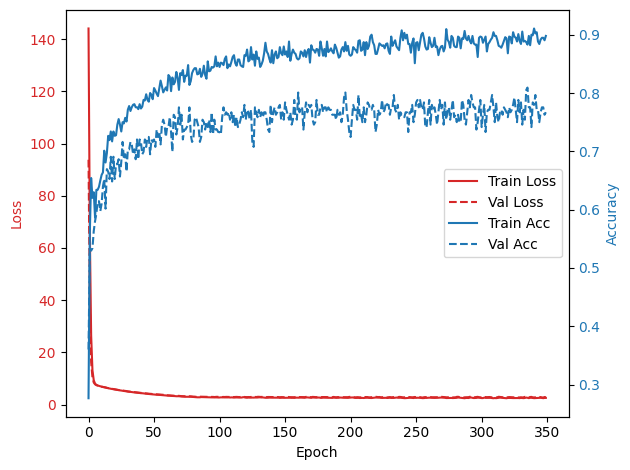

8/8 [==============================] - 0s 2ms/step


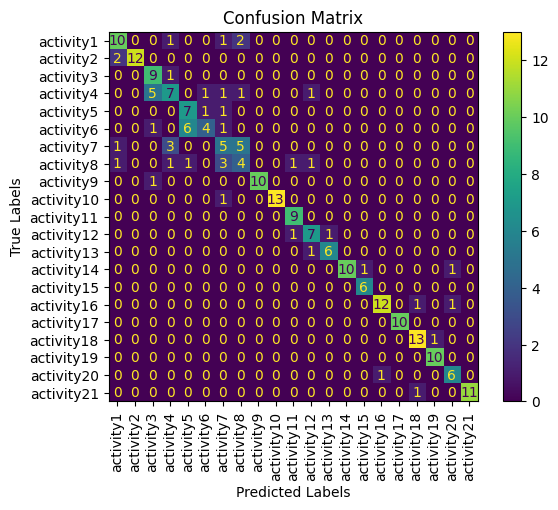

y_val (236, 21)


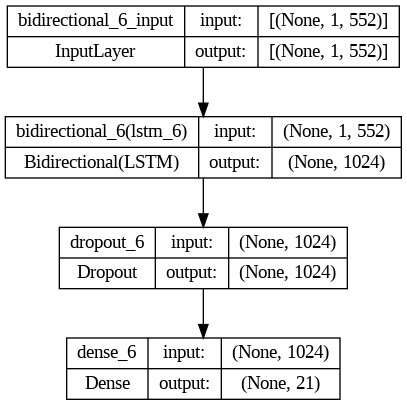

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the validation set
y_val_pred = model.predict(X_test)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_test.shape)

from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))


Bidirectional GRU

In [5]:
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf

from keras.optimizers import Adam
from keras.losses import KLDivergence

# Define the optimizer
optimizer = Adam(learning_rate=0.0005)


# Define L1/L2 regularizer
l1_l2_reg = l1_l2(l1=0.002, l2=0.002)

model = Sequential()
model.add(Bidirectional(GRU(64,
              recurrent_regularizer=l1_l2_reg,
              kernel_regularizer=l1_l2_reg,
              bias_regularizer=l1_l2_reg
), input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(Dropout(0.6))
model.add(Dense(21, activation='softmax'))


# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Compile and fit the model
model.compile(loss=KLDivergence(), optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=600, batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


Epoch 1/600
15/15 [==============================] - 11s 60ms/step - loss: 25.0371 - accuracy: 0.1202 - val_loss: 23.1796 - val_accuracy: 0.2924
Epoch 2/600
15/15 [==============================] - 0s 7ms/step - loss: 22.0851 - accuracy: 0.2872 - val_loss: 20.5358 - val_accuracy: 0.4407
Epoch 3/600
15/15 [==============================] - 0s 7ms/step - loss: 19.5187 - accuracy: 0.4053 - val_loss: 18.1852 - val_accuracy: 0.5085
Epoch 4/600
15/15 [==============================] - 0s 7ms/step - loss: 17.2496 - accuracy: 0.5032 - val_loss: 16.0643 - val_accuracy: 0.5805
Epoch 5/600
15/15 [==============================] - 0s 7ms/step - loss: 15.1455 - accuracy: 0.5617 - val_loss: 14.1505 - val_accuracy: 0.6186
Epoch 6/600
15/15 [==============================] - 0s 7ms/step - loss: 13.3235 - accuracy: 0.5979 - val_loss: 12.4209 - val_accuracy: 0.6568
Epoch 7/600
15/15 [==============================] - 0s 7ms/step - loss: 11.6476 - accuracy: 0.6447 - val_loss: 10.8694 - val_accuracy: 0.67

8/8 [==============================] - 1s 2ms/step
Validation Set Metrics:
Accuracy: 0.8136
Precision: 0.8172
Recall: 0.8136
F1-Score: 0.8113


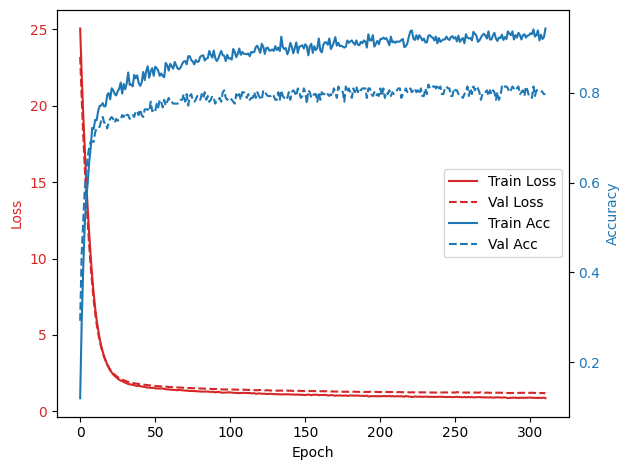

8/8 [==============================] - 0s 2ms/step


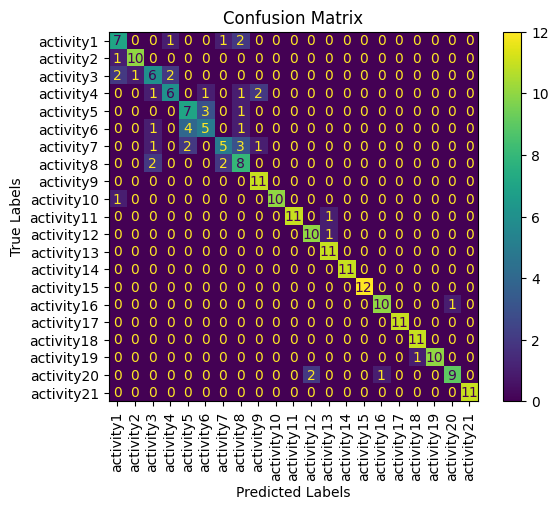

y_val (236, 21)


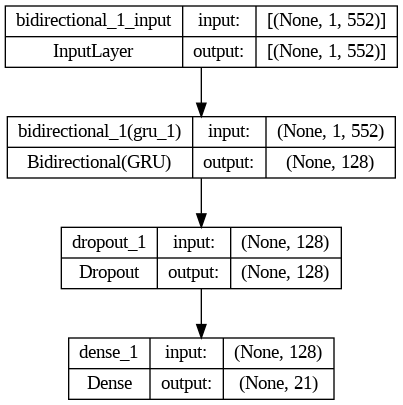

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the validation set
y_val_pred = model.predict(X_test)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_test.shape)

from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))


Cross Validation of the GRU Model

In [ ]:
from sklearn.model_selection import KFold
from keras.regularizers import l1_l2
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dropout, Dense
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

# Assuming X is your feature DataFrame and y is your target NumPy array
# Converting X to a NumPy array can help with indexing
X_array = X.to_numpy()
y_array = y  # Since y is already a NumPy array, no need to convert

# Number of splits
n_splits = 5

# KFold Cross Validation
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
val_loss_scores = []
val_acc_scores = []

# Loop through the k-folds
for train_index, val_index in kf.split(X_array):
    X_train_fold, X_val_fold = X_array[train_index], X_array[val_index]
    y_train_fold, y_val_fold = y_array[train_index], y_array[val_index]

    # Standardize the features (important to avoid data leakage, hence done inside the loop)
    scaler = StandardScaler()
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)

    # Reshape data to be 3D, if it's 2D
    if len(X_train_fold.shape) == 2:
        X_train_fold = np.reshape(X_train_fold, (X_train_fold.shape[0], 1, X_train_fold.shape[1]))
        X_val_fold = np.reshape(X_val_fold, (X_val_fold.shape[0], 1, X_val_fold.shape[1]))

    # Build the model
    l1_l2_reg = l1_l2(l1=0.002, l2=0.002)

    model = Sequential()
    model.add(Bidirectional(GRU(128,
                  recurrent_regularizer=l1_l2_reg,
                  kernel_regularizer=l1_l2_reg,
                  bias_regularizer=l1_l2_reg
    ), input_shape=(X_train_fold.shape[1], X_train_fold.shape[2])
    ))
    model.add(Dropout(0.6))
    model.add(Dense(21, activation='softmax'))

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Compile and fit the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_fold, y_train_fold, epochs=350, batch_size=64,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping], verbose=0)  # Set verbose=0 for less output

    # Evaluate the model
    val_loss, val_acc = model.evaluate(X_val_fold, y_val_fold, verbose=0)

    # Append the scores
    val_loss_scores.append(val_loss)
    val_acc_scores.append(val_acc)

# Average scores
avg_val_loss = np.mean(val_loss_scores)
avg_val_acc = np.mean(val_acc_scores)

print(f"Average validation loss: {avg_val_loss}")
print(f"Average validation accuracy: {avg_val_acc}")


Average validation loss: 1.5498380661010742
Average validation accuracy: 0.8104038953781127


MLP model

In [ ]:
from tensorflow.keras.layers import Flatten
from keras.regularizers import l2

# MLP model with dropout and L2 regularization
model = Sequential()
model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))  # Add Flatten layer
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(21, activation='softmax'))  # 21 units for 21 classes

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25)

# Compile and fit the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


Epoch 1/200
30/30 [==============================] - 2s 10ms/step - loss: 6.3514 - accuracy: 0.0819 - val_loss: 5.2896 - val_accuracy: 0.2161
Epoch 2/200
30/30 [==============================] - 0s 4ms/step - loss: 5.3657 - accuracy: 0.1957 - val_loss: 4.8870 - val_accuracy: 0.3686
Epoch 3/200
30/30 [==============================] - 0s 4ms/step - loss: 4.9665 - accuracy: 0.2500 - val_loss: 4.5402 - val_accuracy: 0.4110
Epoch 4/200
30/30 [==============================] - 0s 4ms/step - loss: 4.5757 - accuracy: 0.3053 - val_loss: 4.1515 - val_accuracy: 0.5508
Epoch 5/200
30/30 [==============================] - 0s 4ms/step - loss: 4.2446 - accuracy: 0.3755 - val_loss: 3.8351 - val_accuracy: 0.5720
Epoch 6/200
30/30 [==============================] - 0s 4ms/step - loss: 3.9529 - accuracy: 0.4032 - val_loss: 3.5533 - val_accuracy: 0.6059
Epoch 7/200
30/30 [==============================] - 0s 4ms/step - loss: 3.6891 - accuracy: 0.4372 - val_loss: 3.3191 - val_accuracy: 0.6525
Epoch 8/200


8/8 [==============================] - 0s 1ms/step
Validation Set Metrics:
Accuracy: 0.7839
Precision: 0.7862
Recall: 0.7839
F1-Score: 0.7806


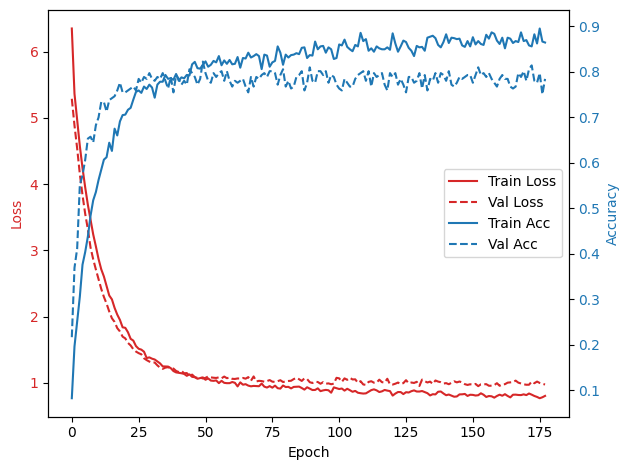

8/8 [==============================] - 0s 1ms/step


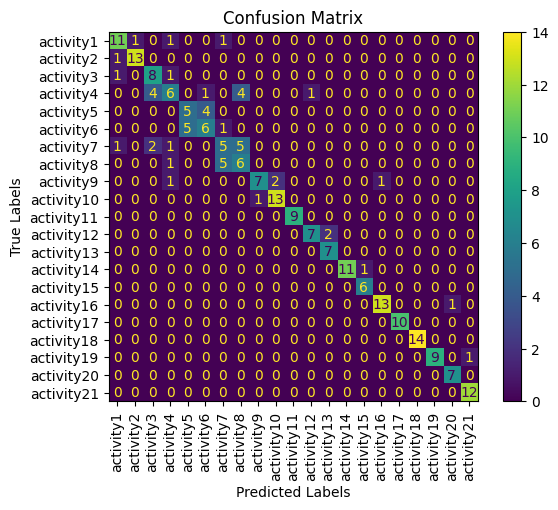

y_val (236, 21)


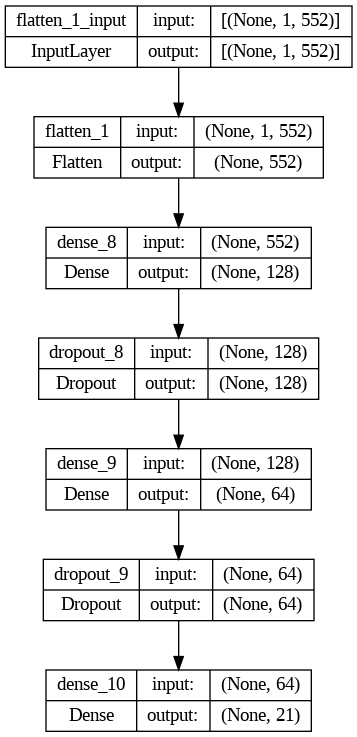

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the validation set
y_val_pred = model.predict(X_test)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Convert probabilities to class labels

y_val_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate metrics
accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
precision = precision_score(y_val_true_classes, y_val_pred_classes, average='weighted')
recall = recall_score(y_val_true_classes, y_val_pred_classes, average='weighted')
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
line1, = ax1.plot(history.history['loss'], color=color, label='Train Loss')
line2, = ax1.plot(history.history['val_loss'], color=color, linestyle='dashed', label='Val Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
line3, = ax2.plot(history.history['accuracy'], color=color, label='Train Acc')
line4, = ax2.plot(history.history['val_accuracy'], color=color, linestyle='dashed', label='Val Acc')
ax2.tick_params(axis='y', labelcolor=color)

# Added this line
lns = [line1, line2, line3, line4]
ax1.legend(handles=lns, loc='center right')

fig.tight_layout()
plt.show()

# Make predictions using the trained model
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix
classes = ['activity' + str(x+1) for x in range(0, 21)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

print("y_val", y_test.shape)

from keras.utils import plot_model
!pip install networkx
from IPython.display import Image, display

# Generate the plot
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
display(Image(filename='model.png'))
